In [1]:
import numpy as np

import argparse, cv2, os, sys, math, random

from pathlib import *

from matplotlib import pyplot as plt

from PIL import Image

from scipy import ndimage

# p3, p3m1, p31m

In [2]:
# general function: 

def rec_crop(image,width,height): # crop a rectangular area 
    h,w = image.shape[:2]
    x=int(np.random.rand(1)*(w-width))
    y=int(np.random.rand(1)*(h-height))
    img_cropped = np.copy(image[y:y+height, x:x+width])
    return img_cropped

def translate_normal(image, W, H):
    (h,w)=image.shape[:2]
    times_H = int(H/h)+1
    times_W = int(W/w)+1  
    p1=image
    for j in range(1,times_H):
        p1=np.concatenate((p1,image))       
    p2=p1   
    for i in range(1,times_W):
        p2=np.concatenate((p2, p1),axis=1)   
    img_trans = p2[:H, :W] 
    return img_trans

def obli_crop(crop, theta): #theta is angle of oblique
    b=crop.shape[0]
    crop1=np.copy(crop)
    (h,w)=crop1.shape[:2]
    theta = math.radians(theta)
    tan = math.tan(theta)
    for i in range (0,h):
        crop1[i,0:int((h-i)/tan),:]=0    
    crop1=np.rot90(crop1,2)
    for i in range (0,h):
        crop1[i,0:int((h-i)/tan),:]=0            
    crop1=np.rot90(crop1,2)
    crop1 = crop1/255.
    return crop1

def border(image): # vague the border
    h,w = image.shape[:2]
    for i in range (0,h-1):
        for j in range (1,w-1):
            if np.sum(image[i,j-1,:])!=0 and np.sum(image[i,j+1,:])!=0 and np.sum(image[i,j,:])==0:
                image[i,j,:] = np.copy(image[i,j+1,:])
            if np.sum(image[i-1,j,:])!=0 and np.sum(image[i+1,j,:])!=0 and np.sum(image[i,j,:])==0:
                image[i,j,:] = np.copy(image[i+1,j,:])
    for i in range (0,h):
        if np.sum(image[i,0,:])==0:
            image[i,0,:]=np.copy(image[i,1,:])
        if np.sum(image[i,w-1,:])==0:
            image[i,w-1,:]=np.copy(image[i,w-2,:])
    for j in range (0,w):
        if np.sum(image[h-1,j,:])==0:
            image[h-1,j,:]=np.copy(image[h-2,j,:])
    return image

def rhombic_edge(image):
    img = np.copy(image)
    h,w = img.shape[:2]
    times = 1
    for i in range (0,int(h/2)):
        for j in range (0,int(w/2)):
            if np.sum(img[i,j,:])==0:
                t=1
                i_h = i
                if i_h < h-1:
                    while np.sum(img[i_h+1,j,:])==0:
                        t=t+1
                        i_h = i_h+1
                    if t > times:
                        times = t
    for q in range(0,times):
        img_1 = np.roll(img,1,axis=0)
        for i in range (0,h):
            for j in range (0,w):
                if np.sum(img[i,j,:])==0:
                    img[i,j,:]=np.copy(img_1[i,j,:])
    return img

def translate_obli(pri_cell, W, H):
    h,w = pri_cell.shape[:2]
    rh = h
    start,end = 0,0
    rw_set = list(np.ones((h))*w)
    
    for j in range (0,h-1):
        for i in range (0,w-1):
            if np.sum(pri_cell[j,i,:])==0 and np.sum(pri_cell[j,i+1,:])!=0:
                start = i
            if np.sum(pri_cell[j,i,:])!=0 and np.sum(pri_cell[j,i+1,:])==0:
                end = i
            rw_set[j]=end-start-1
    rw = int(max(rw_set, key = rw_set.count)) #return most frequent number
    
    extra_times = int(w/rw)+1
    times_w=int(W/rw+2*extra_times)
    img = np.zeros((h, int(rw*times_w), 3))
    img[:h,:w,:]=np.copy(pri_cell)
    
    for i in range (0,h):
        for j in range (rw, rw*times_w-rw):
            if np.sum(img[i,j:(j+rw),:])==0 and np.sum(img[i,j-1,:])!=0:
                img[i,j:(j+rw),:]=img[i,(j-rw):j,:]
    start_w = rw*(int(w/rw)+1)
    img = img[:,start_w:int(rw*times_w-rw),:]

    rolled = np.copy(img)
    times_h=int(H/h+1)
    for t in range (0, times_h):
        rolled = np.roll(rolled, 2*rw-w, axis=1)
        img = np.vstack((img,rolled))

    img = img[:H,:W,:]  
    return img

# Specfic function:

In [3]:
# p3:
def translate_p3(pri_cell, W, H):
    h,w = pri_cell.shape[:2]
    rh=h
    rw = int(2*w/3)
    
    times_w=int(W/rw+(w/rw)+1)
    img = np.zeros((h, int(rw*times_w), 3))
    img[:h,:w,:]=np.copy(pri_cell)
    
    img_rolled = np.copy(img)
    for times in range (0,times_w+1):
        img_rolled = np.roll(img_rolled,rw,axis=1)
        for i in range (0,h):
            for j in range (0, rw*times_w):
                if np.sum(img[i,j,:])==0:
                    img[i,j,:] = np.copy(img_rolled[i,j,:]) 
    
    rolled = np.copy(img)
    times_h=int(H/h+1)
    for t in range (0, times_h):
        rolled = np.roll(rolled, 2*rw-w, axis=1)
        img = np.vstack((img,rolled))
        
    img = img[:H,:W,:] 
    return img 

def p3_unit(obli):   # fix the edge problem later
    obli = obli*255.
    r1 = np.rot90(obli)
    r1_im = Image.fromarray(np.uint8(r1)) # have to transfer with uint8 type
    r1 = np.array(r1_im)
    r2_im = r1_im.rotate(120)
    r2 = np.array(r2_im)
    r4 = np.copy(r2)

    r3_im = r2_im.rotate(120, expand=True)
    r3 = np.array(r3_im)
    for i in range (0,4):
        hh = r3.shape[0]
        while np.sum(r3[0,:,:])==0:
            r3 = r3[1:hh]
        r3 = np.rot90(r3)
    h3,w3 = r3.shape[:2]
    r3_top = r3[:int(h3/2)]
    r3_bottom = r3[-int(h3/2):]

    r124 = np.hstack((r2,r1,r4))
    h,w = r124.shape[:2]
    r3_resize = np.zeros((h,w,3))
    r3_resize[-int(h3/2):,:w3,:] = np.copy(r3_top)
    r3_resize[:int(h3/2),-w3:,:] = np.copy(r3_bottom)
    r3_resize1 = np.roll(r3_resize,1,axis=1)
    r3_resize2 = np.roll(r3_resize,-1,axis=1)

    for i in range (0,h):
        for j in range (0,w):
            if np.sum(r124[i,j,:])==0:
                r124[i,j,:]=np.copy(r3_resize[i,j,:])
            if np.sum(r124[i,j,:])==0:
                r124[i,j,:]=np.copy(r3_resize1[i,j,:])
            if np.sum(r124[i,j,:])==0:
                r124[i,j,:]=np.copy(r3_resize2[i,j,:])
    unit = obli_crop(r124, 60)

    return unit

def p3(image, unit_h, Width, Height):
    rec = rec_crop(image,int(unit_h*math.sqrt(3)),unit_h) 
    # width = height*sqrt(3)
    crop = obli_crop(rec, 60)
    unit_p3 = p3_unit(crop)
    obli_p3=translate_p3(unit_p3,Width,Height)
    obli_p3=border(obli_p3)
    return obli_p3

In [69]:
# p3m1:
def rhomb_p3m1(crop):
    h,w = crop.shape[:2]
    for i in range (0,w):
        if np.sum(crop[0,i-1,:])==0 and np.sum(crop[0,i,:])!=0:
            x=i 
    left = np.copy(crop[:,:(w-x),:])
    left = cv2.flip(left, 1, dst=None)

    ww = left.shape[1]
    for i in range (0,h):
        left[i,0:int(ww/2-i*ww/2/h),:]=0    
    right = np.copy(left)
    left = cv2.flip(left, 1, dst=None)
    right_im = Image.fromarray((right * 255).astype(np.uint8))
    right_im = right_im.rotate(60,expand=True)
    right = np.array(right_im)
    for i in range (0,2):
        hh = right.shape[0]
        while np.sum(right[0,:,:])==0:
            right = right[1:hh]
        right = np.rot90(right,2)
    
    hh,ww = left.shape[:2]
    right = np.copy(right[-hh:,-ww:,:])
    hhr, wwr = right.shape[:2]
    
    
    right_r = np.zeros((hh,ww,3))
    if hhr < hh or wwr < ww:
        right_r[:hhr,:wwr,:] = np.copy(right)
        if hhr < hh:
            right_r[-(hh-hhr):,:,:] = np.copy(right[-(hh-hhr):,:,:])
        if wwr < ww :
            right_r[-(ww-wwr):,:,:] = np.copy(right[-(ww-wwr):,:,:])
    else:
        right_r = np.copy(right)
        
    unit_core = np.zeros((h,w,3))
    unit_core[:hh,:ww,:] = np.copy(((left * 255).astype(np.uint8)))
    unit_core_1 = np.copy(unit_core)
    unit_core_1[-hh:,-ww:,:] = np.copy(right)
    for i in range (0,h):
        for j in range (0,w):
            if np.sum(unit_core[i,j,:])==0:
                unit_core[i,j,:]=np.copy(unit_core_1[i,j,:])
    return unit_core

def p3m1(image, unit_h, Width, Height):
    rec = rec_crop(image,int(unit_h*math.sqrt(3)),unit_h)  
    crop = obli_crop(rec, 60)
    crop1 = rhomb_p3m1(crop)  # crop a rhombic for p3m1
    unit_p3m1 = p3_unit(crop1) # form a p3 unit
    obli_p3m1=translate_p3(unit_p3m1,Width,Height)
    obli_p3m1=border(obli_p3m1) 
    obli_p3m1=rhombic_edge(obli_p3m1) # remove black dot
    return obli_p3m1

In [62]:
# p31m:

def rhomb_p31m(crop):
    h,w = crop.shape[:2]
    p1 = np.copy(crop)
    for i in range (0,h):
        p1[i,0:int(w-i*w/h),:]=0 
    p2 = cv2.flip(p1,0,dst=None)
    p2_im = Image.fromarray((p2 * 255).astype(np.uint8))
    p2_im = p2_im.rotate(60,expand=True)
    p2 = np.array(p2_im)
#     p2 = ndimage.rotate(p2,60) #rotation angle in degree
    
    for i in range (0,4):
        hh = p2.shape[0]
        while np.sum(p2[0,:,:])==0:
            p2 = p2[1:hh]
        p2 = np.rot90(p2,1)
#     p2 = p2[-h:,:,:] 
    for i in range (0,4):
        hh = p1.shape[0]
        while np.sum(p1[0,:,:])==0:
            p1 = p1[1:hh]
        p1 = np.rot90(p1,1)
    h,w = p1.shape[:2]

    rhombic = np.copy(((p1 * 255).astype(np.uint8)))
    for i in range (0,h):
        for j in range (0,w):
            if np.sum(rhombic[i,j,:])==0:
                rhombic[i,j,:]=np.copy(p2[i,j,:])
    return rhombic

def p31m(image, unit_h, Width, Height): 
    rec = rec_crop(image,int(unit_h*math.sqrt(3)),unit_h)
    crop = obli_crop(rec, 60)
    rhombic_p31m= rhomb_p31m(crop) # create p31m rhombic
    unit_p31m = p3_unit(rhombic_p31m) # form a p3 unit
    unit_p31m = border(unit_p31m) # remove black dot
    obli_p31m=translate_p3(unit_p31m,Width,Height) #translate
#     obli_p31m=border(obli_p31m) # remove black dot
    obli_p31m=rhombic_edge(obli_p31m)
    return obli_p31m

In [6]:
# p6: 

def rhomb_p6(crop):
    h,w = crop.shape[:2]
    p1 = np.copy(crop)
    for i in range (0,h):
        p1[i,0:int(w-i*w/h),:]=0 
    p2 = np.rot90(p1,2)
    p2_roll = np.roll(p2,1,axis=1)
    
    rhombic = np.copy(p1)
    for i in range (0,h):
        for j in range (0,w):
            if np.sum(rhombic[i,j,:])==0:
                rhombic[i,j,:]=np.copy(p2_roll[i,j,:])
            if np.sum(rhombic[i,j,:])==0:
                rhombic[i,j,:]=np.copy(p2[i,j,:])
    return rhombic

def p6(image, unit_h, Width, Height):
    rec = rec_crop(image,int(unit_h*math.sqrt(3)),unit_h)
    crop = obli_crop(rec, 60) 
    rhombic_p6= rhomb_p6(crop) # create p6 rhombic
    unit_p6 = p3_unit(rhombic_p6) # form a p3 unit
    obli_p6=translate_p3(unit_p6,Width,Height) # translate
    obli_p6=border(obli_p6) # remove black dot
    # obli_p6=border(obli_p6)  # remove black dot
    return obli_p6

In [7]:
# p6m:
def p6m(image, unit_h, Width, Height):
    rec = rec_crop(image,int(unit_h*math.sqrt(3)),unit_h)
    crop = obli_crop(rec, 60) 
    rhombic_p3m1 = rhomb_p3m1(crop)  

    # crop a rhombic for p3m1 :
    rhombic_p6m= rhomb_p6(rhombic_p3m1) 

    # perform p6 rhombic crop, get a p6m rhombic :
    unit_p6m = p3_unit(rhombic_p6m)
    unit_p6m = border(unit_p6m)
    
    # form a p6m unit:
    obli_p6m=translate_obli(unit_p6m,256,256) # translate

    #     obli_p6m=border(obli_p6m) # remove blank border 
    obli_p6m=rhombic_edge(obli_p6m)
    obli_p6m=border(obli_p6m)
    return obli_p6m

# Validate with image sample

In [8]:
import cv2, math, os, random
import numpy as np
import matplotlib.pyplot as plt

# Load image

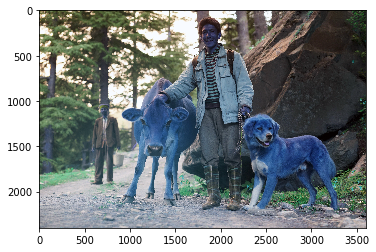

In [9]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/dog-park.png') 
image1 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image1)

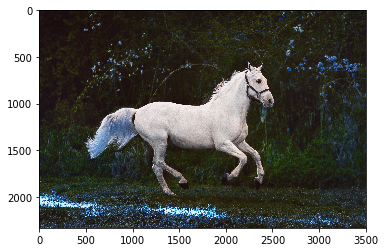

In [10]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/horse.png') 
image2 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image2)

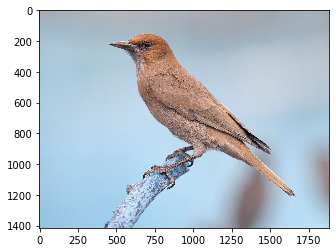

In [11]:
# use image samples for demontration
ori = cv2.imread('/home/yig319/Dropbox/wallpaper_group_generator/Original_images/bird.png') 
image3 = np.copy(ori) # load image used to crop and transform
imgplot = plt.imshow(image3)

# Set image size

In [12]:
#set output image size 
width, height = (256, 256)

# use random size and angle as croped part of image
angle = random.randint(30,85)
unit_h = random.randint(20,80)
lower_bound_w = int(unit_h/math.tan(math.radians(angle)))
if lower_bound_w > 65:
    unit_w = random.randint(lower_bound_w+15, lower_bound_w+75)
else: 
    unit_w = random.randint(lower_bound_w+15, 85)
    
# width, length, angle of unit cell:
unit_w, unit_h, angle

(79, 79, 73)

# Transform

In [70]:
p3_1 = p3(image1,unit_w,width,height)

p3m1_1 = p3m1(image1,unit_w,width,height)

p31m_1 = p31m(image1,unit_w,width,height)

p6_1 = p6(image1,unit_w,width,height)

p6m_1 = p6m(image1,unit_w,width,height)

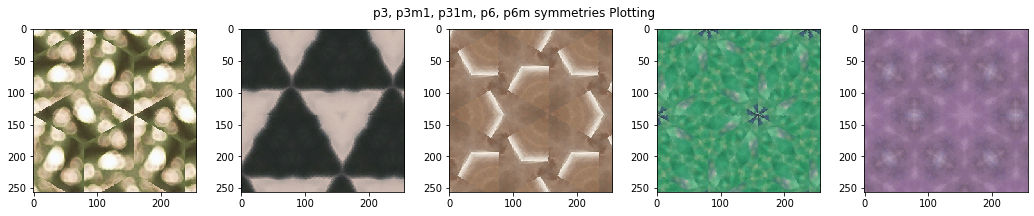

In [71]:
plt.figure(figsize=(18, 3))
plt.subplot(151)
plt.imshow(p3_1)
plt.subplot(152)
plt.imshow(p3m1_1)
plt.subplot(153)
plt.imshow(p31m_1)
plt.subplot(154)
plt.imshow(p6_1)
plt.subplot(155)
plt.imshow(p6m_1)

plt.suptitle('p3, p3m1, p31m, p6, p6m symmetries Plotting')
plt.show()

In [72]:
p3_1 = p3(image2,unit_w,width,height)

p3m1_1 = p3m1(image2,unit_w,width,height)

p31m_1 = p31m(image2,unit_w,width,height)

p6_1 = p6(image2,unit_w,width,height)

p6m_1 = p6m(image2,unit_w,width,height)

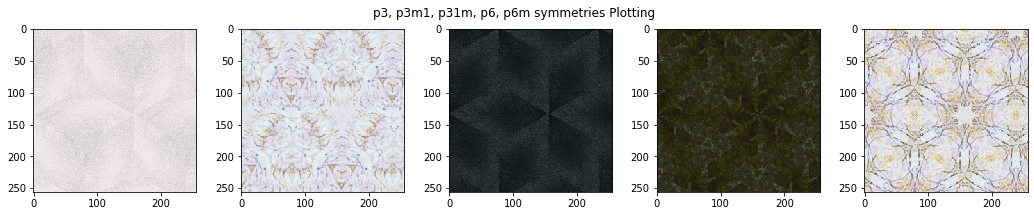

In [73]:
plt.figure(figsize=(18, 3))
plt.subplot(151)
plt.imshow(p3_1)
plt.subplot(152)
plt.imshow(p3m1_1)
plt.subplot(153)
plt.imshow(p31m_1)
plt.subplot(154)
plt.imshow(p6_1)
plt.subplot(155)
plt.imshow(p6m_1)

plt.suptitle('p3, p3m1, p31m, p6, p6m symmetries Plotting')
plt.show()

In [74]:
p3_1 = p3(image3,unit_w,width,height)

p3m1_1 = p3m1(image3,unit_w,width,height)

p31m_1 = p31m(image3,unit_w,width,height)

p6_1 = p6(image3,unit_w,width,height)

p6m_1 = p6m(image3,unit_w,width,height)

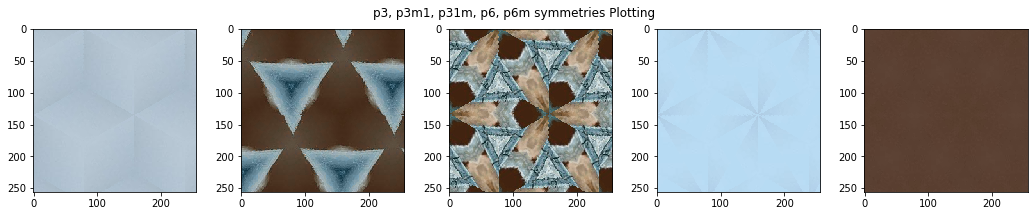

In [75]:
plt.figure(figsize=(18, 3))
plt.subplot(151)
plt.imshow(p3_1)
plt.subplot(152)
plt.imshow(p3m1_1)
plt.subplot(153)
plt.imshow(p31m_1)
plt.subplot(154)
plt.imshow(p6_1)
plt.subplot(155)
plt.imshow(p6m_1)

plt.suptitle('p3, p3m1, p31m, p6, p6m symmetries Plotting')
plt.show()